In [1]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the cleaned CSV
df = pd.read_csv("/Users/sruthiuma/Documents/PrototypeSIH/dataset/monsoon_cleaned.csv")

# Show first 5 rows
df.head()


,STATE_UT,DISTRICT,BLOCK,VILLAGE,LATITUDE,LONGITUDE,Date,DTWL
0,Andhra Pradesh,Alluri Sitharama Raju,Addateegala,Addateegala,17.4633,82.0271,2024-05-10,9.54
1,Andhra Pradesh,Alluri Sitharama Raju,Addateegala,Addateegala,17.4633,82.0271,2023-05-01,8.72
2,Andhra Pradesh,Alluri Sitharama Raju,Addateegala,Addateegala,17.4633,82.0271,2022-05-01,8.43
3,Andhra Pradesh,Alluri Sitharama Raju,Addateegala,Addateegala,17.4633,82.0271,2019-05-01,8.11
4,Andhra Pradesh,Alluri Sitharama Raju,Addateegala,Addateegala,17.4633,82.0271,2018-05-01,7.61


In [3]:
# Data types and nulls
df.info()

# Quick statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7686 entries, 0 to 7685
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATE_UT   7686 non-null   object 
 1   DISTRICT   7684 non-null   object 
 2   BLOCK      7686 non-null   object 
 3   VILLAGE    7686 non-null   object 
 4   LATITUDE   7686 non-null   float64
 5   LONGITUDE  7686 non-null   float64
 6   Date       7686 non-null   object 
 7   DTWL       7686 non-null   float64
dtypes: float64(3), object(5)
memory usage: 480.5+ KB


,LATITUDE,LONGITUDE,DTWL
count,7686.000000,7686.000000,7686.000000
mean,16.060881,80.542908,7.768318
std,1.533594,1.904572,9.594848
min,12.654790,76.848400,0.010000
25%,14.750420,79.198360,3.070000
50%,16.255895,80.259310,5.180000
75%,17.100700,81.952300,8.570000
max,19.118380,84.686460,100.100000


In [5]:
# Sort by Village and Date
df = df.sort_values(["VILLAGE", "Date"])

# Create lag features for previous 1 and 2 months
df["Lag1"] = df.groupby("VILLAGE")["DTWL"].shift(1)
df["Lag2"] = df.groupby("VILLAGE")["DTWL"].shift(2)

# Drop rows with NaN (first 2 rows per village)
df = df.dropna().reset_index(drop=True)

# Extract year and month from Date
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

df.head()


,STATE_UT,DISTRICT,BLOCK,VILLAGE,LATITUDE,LONGITUDE,Date,DTWL,Lag1,Lag2,Year,Month
0,Andhra Pradesh,Bapatla,Addanki,Addanki,15.82731,79.9723,2018-05-01,4.62,4.48,7.91,2018,5
1,Andhra Pradesh,Bapatla,Addanki,Addanki,15.82731,79.9723,2019-05-01,13.80,4.62,4.48,2019,5
2,Andhra Pradesh,Bapatla,Addanki,Addanki,15.82731,79.9723,2022-05-01,3.49,13.80,4.62,2022,5
3,Andhra Pradesh,Bapatla,Addanki,Addanki,15.82731,79.9723,2023-05-01,3.01,3.49,13.80,2023,5
4,Andhra Pradesh,Bapatla,Addanki,Addanki,15.82731,79.9723,2024-05-10,3.85,3.01,3.49,2024,5


In [6]:
# If you want to include village as a feature
df = pd.get_dummies(df, columns=["VILLAGE"], drop_first=True)
df.head()


,STATE_UT,DISTRICT,BLOCK,LATITUDE,LONGITUDE,Date,DTWL,Lag1,Lag2,Year,...,VILLAGE_Y.Cherlopalle,VILLAGE_Yanadipalli,VILLAGE_Yanam,VILLAGE_Yelamanchili,VILLAGE_Yemmiganur,VILLAGE_Yendapalli,VILLAGE_Yerragonda,VILLAGE_Yerraguntla,VILLAGE_Zullakallu,VILLAGE_Zupudi
0,Andhra Pradesh,Bapatla,Addanki,15.82731,79.9723,2018-05-01,4.62,4.48,7.91,2018,...,False,False,False,False,False,False,False,False,False,False
1,Andhra Pradesh,Bapatla,Addanki,15.82731,79.9723,2019-05-01,13.80,4.62,4.48,2019,...,False,False,False,False,False,False,False,False,False,False
2,Andhra Pradesh,Bapatla,Addanki,15.82731,79.9723,2022-05-01,3.49,13.80,4.62,2022,...,False,False,False,False,False,False,False,False,False,False
3,Andhra Pradesh,Bapatla,Addanki,15.82731,79.9723,2023-05-01,3.01,3.49,13.80,2023,...,False,False,False,False,False,False,False,False,False,False
4,Andhra Pradesh,Bapatla,Addanki,15.82731,79.9723,2024-05-10,3.85,3.01,3.49,2024,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# Features
feature_cols = ["Year", "Month", "Lag1", "Lag2"] + [col for col in df.columns if col.startswith("VILLAGE_")]

X = df[feature_cols]
y = df["DTWL"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Initialize models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

best_model = None
best_model_name = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} R2 Score: {r2:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_model_name = name

print(f"\n✅ Best Model: {best_model_name} with R2 = {best_r2:.4f}")

# Save the best model
joblib.dump(best_model, f"best_model.pkl")


LinearRegression R2 Score: 0.4164
RandomForest R2 Score: 0.3832
GradientBoosting R2 Score: 0.4292

✅ Best Model: GradientBoosting with R2 = 0.4292


['best_model.pkl']

In [9]:
# Predict next 6 months
last_date = df["Date"].max()
future_dates = pd.date_range(last_date + pd.DateOffset(days=1), periods=6, freq='M')

# Use last known Lag1 and Lag2 values (overall)
lag1 = df["DTWL"].iloc[-1]
lag2 = df["DTWL"].iloc[-2]

predictions = []

for date in future_dates:
    X_new = pd.DataFrame({
        "Year": [date.year],
        "Month": [date.month],
        "Lag1": [lag1],
        "Lag2": [lag2]
    })
    
    # Add village columns as zeros (since one-hot)
    for col in X.columns:
        if col.startswith("VILLAGE_"):
            X_new[col] = 0
    
    pred = best_model.predict(X_new)[0]
    predictions.append({
        "Date": date,
        "Predicted_DTWl": pred
    })
    
    # Update lags
    lag2 = lag1
    lag1 = pred

pred_df = pd.DataFrame(predictions)
pred_df


,Date,Predicted_DTWl
0,2024-05-31,6.035689
1,2024-06-30,7.835956
2,2024-07-31,8.669120
3,2024-08-31,11.235145
4,2024-09-30,13.449865
5,2024-10-31,13.418533


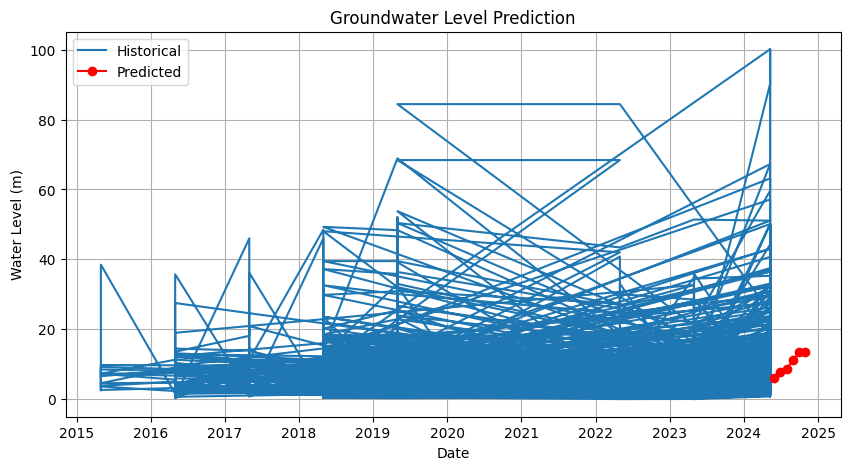

In [10]:
plt.figure(figsize=(10,5))
plt.plot(df["Date"], df["DTWL"], label="Historical")
plt.plot(pred_df["Date"], pred_df["Predicted_DTWl"], marker='o', label="Predicted", color="red")
plt.xlabel("Date")
plt.ylabel("Water Level (m)")
plt.title("Groundwater Level Prediction")
plt.legend()
plt.grid(True)
plt.show()
